In [71]:
#Die ganzen packages die für den versuch verwendet werden

import numpy as np #numpy ist ein package mit allen mathematischen ausdrücken/funktionen/operationen/etc. 
from uncertainties import ufloat #Uncertainties ist für das automatische berrechnen von unsicherheiten
from uncertainties.umath import * #Importieren von rechnen mit uncertainties (addition/multiplikation/etc.)
from uncertainties import unumpy as unp #kann arrays von unsicherheiten verstehen (also eine liste, statt jede zahl einzeln einzutippen)
from IPython.display import Latex, HTML, Math, display # Um ergebnisse schöner anzuzeigen. display() "ersetzt" quasi print(), und lässt latex fromatierung zu
import matplotlib.pyplot as plt #Damit kann man graphen plotten
from scipy.optimize import curve_fit

import pandas as pd #Um die Spektroskopie daten zu lesen
from scipy.signal import find_peaks #um die maxima von listen (also auch y-achse) zu finden


#funktion für mittwlert mit fehler defnieren (um später ein uarray mit unsicherheiten direkt zu einem mittelwert zu machen)
def mean(values):
    nom = unp.nominal_values(values)
    std_mean = np.std(nom, ddof=1) / np.sqrt(len(nom))
    return ufloat(np.mean(nom), std_mean)



In [72]:
#Farbige wellenlänge

#dieser code ist nur um Spektrum farbig zu machen

def wavelength_to_rgb(wavelength):
    gamma = 0.8
    intensity_max = 255
    factor = 0.0
    R = G = B = 0

    if 380 <= wavelength < 440:
        R = -(wavelength - 440) / (440 - 380)
        G = 0.0
        B = 1.0
    elif 440 <= wavelength < 490:
        R = 0.0
        G = (wavelength - 440) / (490 - 440)
        B = 1.0
    elif 490 <= wavelength < 510:
        R = 0.0
        G = 1.0
        B = -(wavelength - 510) / (510 - 490)
    elif 510 <= wavelength < 580:
        R = (wavelength - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif 580 <= wavelength < 645:
        R = 1.0
        G = -(wavelength - 645) / (645 - 580)
        B = 0.0
    elif 645 <= wavelength <= 780:
        R = 1.0
        G = 0.0
        B = 0.0

    if 380 <= wavelength < 420:
        factor = 0.3 + 0.7 * (wavelength - 380) / (420 - 380)
    elif 420 <= wavelength < 645:
        factor = 1.0
    elif 645 <= wavelength <= 780:
        factor = 0.3 + 0.7 * (780 - wavelength) / (780 - 645)

    R = ((R * factor) ** gamma)
    G = ((G * factor) ** gamma)
    B = ((B * factor) ** gamma)

    return (R, G, B)

# Brechung, Dispersion und Spektroskopie

## Dispersionskurve eines optischen Glases

Es wird die Disperionskurve eines Optischen Glases mittels Spektroskopie bestimmt. 

### Durchführung und Versuchsaufbau  

Mit einem Prismenspektrometer wird der Winkel der minimalen Ablenkung für fünf Spektrallinien einer Quecksilberdampflampe bestimmt.  
Zuerst wird die Richtung des unabgelenkten Lichtstrahls gemessen, anschließend das Prisma auf dem Prismentisch positioniert und so ausgerichtet, dass das Spektrum sichtbar wird.  
Durch Drehen des Prismentisches wird die Stellung der minimalen Ablenkung gefunden. Die Differenz der gemessenen Winkel ergibt den Ablenkwinkel, aus dem die Brechungsindizes für die jeweiligen Wellenlängen berechnet werden.  

Danach wird das Prisma entfernt und das Linienspektrum der Quecksilberdampflampe mit einem automatischen Gitterspektrometer und der Software *OceanView* aufgenommen.  
Die Spaltbreite sowie die Integrationszeit werden so angepasst, dass einzelne Spektrallinien klar getrennt sichtbar sind.  
Aus den ermittelten Daten wird anschließend die Dispersionskurve $n(\lambda)$ erstellt und mit Literaturwerten verglichen, um das Material des Prismas zu bestimmen.  

### Auflösung bzw. Unsicherheit der Messgeräte:

* Goniometer 1′ (Winkelminute)
* Lineal zur Justierung: 0.5 mm 

### Erläuterung der systematischen (Typ-B) Unsicherheit der Messwerte:

Die Unsicherheit der Winkelablesung kann durch Parallaxenfehler steigen.  
Zusätzlich kann das Prisma beim Drehen leicht verrutschen oder nicht exakt in der Symmetrieposition stehen, was zu fehlerhaften Ablenkwinkeln führt.  

### Ergebnisse:


Die mittels Goniometer bestimmten Minimal Winkel und den Dementsprechenden Brechungsindizes sind in Tabelle 1. angeführt.

In [78]:
#Goniometer: Spektrallinien einer Quecksilberlampe

#Spektrallinien Winkel:

# Unsicherheit vom winkel nach augenmaß (höher als auflösung vom goniometer = 0.01)
Winkel_std = 1/60
# Epsilon winkel vom Prisma:
e = 60

#türkis = 315.0,

#                          Gelb      Grün     Blau   Lila     
ungebrochen = unp.uarray([ 354 ], Winkel_std)
gebrochen   = unp.uarray([ 315.2 + 5/60 , 315.1 +5/60 ,  314.9 +4/60 , 314.50  ], Winkel_std)

delta_min = ungebrochen - gebrochen
delta_min = unp.uarray(unp.nominal_values(delta_min), unp.std_devs(delta_min)+0.1)
n_wert = unp.sin((delta_min + e)/2 * np.pi/180) / unp.sin(e/2 * np.pi/180) # * np.pi/180 weil np.sin nur mit Bogenmaß arbeitet (!!!nicht mit winkelmaß!!!)


n = unp.uarray(unp.nominal_values(n_wert), unp.std_devs(n_wert) + 0.01) # Unischerheit von n anpassen (in diesem falls + 0.01)


#----------------------------------------------------------------------------------------------------------------------------------------------
#
# Ab hier alles nur um die Tabellen schön darzustellen. Man könnte auch einfach print(n) und print(delta_min) machen ist aber uuuurrrr schirch
#
#----------------------------------------------------------------------------------------------------------------------------------------------


meine_lieblingsfarben = (["Gelb", "Grün", "Blau", "Lila"])

#Minimum winkel als Tabelle anzeigen
table = r"""$$
\begin{array}{c|c|c}
\textbf{Farbe} & \textbf{Min. Winkel} ~\delta_{min}~\mathrm[°] & \textbf{Brechungsindex} ~n~ \\ \hline \\
"""
for i, (farbe,Delta,n_i) in enumerate(zip(meine_lieblingsfarben, delta_min, n)):
    table += rf"\mathrm{{{farbe}}} & ({Delta:.2f}) & ({n_i:.2f}) \\ "
table += r"\end{array}$$"

display(Latex(table))

<IPython.core.display.Latex object>

Das Spektrum der Quecksilberdampflampe im Vergleich zum brechungsindex wird in Tabelle 2 gezeigt, wobei Abbildung 1 das aufgenommene Spektrum zeigt und Abbildung 2 die Dispersionkurve.

<IPython.core.display.Latex object>

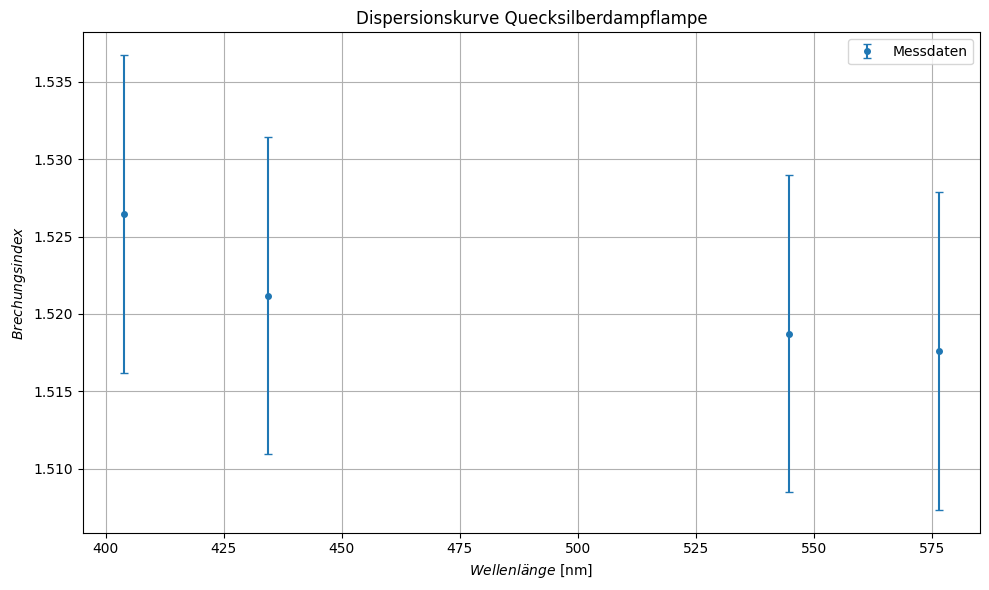

In [74]:
#Spektrum der Quecksilberdampflampe


Spektrum = pd.read_csv("GPT-Data.csv", sep=',', decimal='.')

wellenlänge_wert = Spektrum['Wavelength'].values            #nm
wellenlänge = wellenlänge_wert
Int = Spektrum['Intensity'].values


# # Create a color list for each wavelength
# colors = [wavelength_to_rgb(wl) for wl in wellenlänge]

# # Plot with color gradient
# plt.figure(figsize=(10, 6))
# for i in range(len(wellenlänge) - 1):
#     plt.plot(wellenlänge[i:i+2], Int[i:i+2], color=colors[i])

# plt.xlabel("$Wellenlänge$ [nm]")
# plt.ylabel("$Intensität$")
# plt.title("Quecksilberdampflampe Spektrum")
# plt.ylim(bottom=-0.1)
# plt.xlim(left=380, right=700)
# plt.grid()
# plt.tight_layout()

# ranges = [(380, 415), (420, 450), (540, 550), (580, 600)]
# peak_positions = []
# peak_values = []


# #Die maxima aus den Daten bestimmen
# for r in ranges:
#     mask = (wellenlänge >= r[0]) & (wellenlänge < r[1])
#     peaks, _ = find_peaks(Int[mask])
#     if len(peaks) > 0:
#         # get index of highest peak in this range
#         local_max_idx = peaks[np.argmax(Int[mask][peaks])]
#         peak_positions.append(wellenlänge[mask][local_max_idx])
#         peak_values.append(Int[mask][local_max_idx])

std = [(576.543-575.478)/2, (545.507-544.789)/2, (435.033-434.292)/2, (404.159-403.786)/2]
peak_positions = unp.uarray( [576.543, 544.789, 434.292, 403.786], std )

meine_lieblingsfarben = (["Gelb", "Grün", "Blau", "Lila"])

#Minimum winkel als Tabelle anzeigen
table = r"""$$
\begin{array}{c|c|c}
\textbf{Farbe} & \textbf{Wellenlänge} ~\lambda~\mathrm[nm] & \textbf{Brechungsindex} ~n~ \\ \hline \\
"""
for i, (farbe,Peak,n_i) in enumerate(zip(meine_lieblingsfarben, peak_positions, n)):
    table += rf"\mathrm{{{farbe}}} & ({Peak:.2f}) & ({n_i:.2f}) \\ "
table += r"\end{array}$$"

display(Latex(table))



λ = unp.nominal_values(peak_positions)
n_values = unp.nominal_values(n)
n_errors = unp.std_devs(n)


plt.figure(figsize=(10, 6))
plt.xlabel("$Wellenlänge$ [nm]")
plt.ylabel("$Brechungsindex$")
plt.errorbar(unp.nominal_values(peak_positions), unp.nominal_values(n), fmt='o',yerr=unp.std_devs(n), capsize=3, markersize=4,label="Messdaten")
plt.title("Dispersionskurve Quecksilberdampflampe")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Diskussion


Die Wellenlängenmessungen ergeben eine der Wahrgenommen Farben passenden Wert, wobei ebenfalls Türkis im Goniometer sichtbar jedoch nicht über das Gitterspektrometer, weswegen dieser Wert ausgelassen wurde.
Die Dispersionkurve hat einen zu erwartenden verlauf und die Brechungsindize liegen im Literaturwert von $n=1.52$ https://de.wikipedia.org/wiki/Optisches_Glas.

## Absorptions-Spektroskopie  

### Durchführung und Versuchsaufbau  

Eine unbekannte Flüssigkeit A wird mithilfe eines Gitterspektrometers mit Küvettenaufsatz untersucht.  
Zuerst wird ein Referenzspektrum ohne Probe aufgenommen, anschließend das Spektrum mit Probe.  
Das Programm *OceanView* berechnet automatisch die Optische Dichte  $OD = -\log T$ und stellt diese gegen die Wellenlänge dar.  

Die Absorptionsmaxima im Spektrum werden identifiziert und mit den bekannten Linien von Neodym und Praseodym verglichen, um die unbekannte Substanz oder mögliche Mischungen zu bestimmen.  
Zum Abschluss werden die Spektren dokumentiert, beschriftet und die Unsicherheiten der Wellenlängen abgeschätzt.  

### Erläuterung der systematischen (Typ-B) Unsicherheit der Messwerte:

Die gemessene Wellenlänge wird mittel FWHM mit einer Unsicherheit abgeschätzt, wobei diese nur nach augenmaß bestimmt wird.


### Ergebnisse:

Tabelle 3 zeigt die Gemessenen Maxima des Absorptionspektrums im vergleich zum Gegebenen Literaturwert des Anleitungstext \cite{Anleitung}

In [75]:
# Praseodym-Daten
lambda_praseodym = np.array([444, 468, 481, 590])  # Literaturwerte [nm]

# Maxima
messwerte = np.array([443, 467.119, 481.409, 589.646])         # OceanView
messwerte_u = unp.uarray(messwerte, [(443-441.695)/2, (467.119-464.181)/2, (481.409-479.214)/2, (589.646-582.925)/2])  # mit Unsicherheit


abweichung = messwerte - lambda_praseodym


Meine_zweit_liebsten_farben = np.array(["blau", "türkisblau", "türkis", "gelborange"])

table = r"""$$
\begin{array}{c|c|c|c}
\textbf{Farbe} & \textbf{$\lambda_\text{Lit}$ [nm]} & \textbf{$\lambda_\text{gemessen}$ [nm]} & \textbf{Abweichung [nm]} \\ \hline
"""

for farbe, lam_lit, lam_meas, diff in zip(Meine_zweit_liebsten_farben, lambda_praseodym, messwerte_u, abweichung):
    lam_meas_str = f"{lam_meas:.0f}"
    table += rf"\mathrm{{{farbe}}} & {lam_lit:.0f} & {lam_meas:.2f} & {abs(diff):.2f} \\ " + "\n"

table += r"\end{array}$$"

display(Latex(table))


<IPython.core.display.Latex object>

### Diskussion

Anhand der mittels Programm abgelesenen Werte ist eine sehr gute übereinstimmung der unbekannten Probe und den Literaturwerten von Praseodym sichtbar.